In [1]:
import time
import gym
import numpy as np
import tensorflow as tf
import tensorflow.keras.layers as layers
import tensorflow.keras.regularizers as reg
from tensorflow_probability import distributions as tfd
import matplotlib.pyplot as plt
import os
tf.enable_eager_execution()


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.



In [2]:
class non_linear_Model(object):
    def __init__(self,thetaacc_error = 0, env_params_variation = [0,0,0,0], initial_state_variation = [0,0,0,0]):
        self.lstm_sizes = [128,128]
        self.thetaacc_error = thetaacc_error
        self.global_epoch = 0
        self.env = gym.make('Custom_CartPole-v0', thetaacc_error=self.thetaacc_error, env_params_var=env_params_variation, initial_state_var=initial_state_variation)
        gravity = self.env.gravity
        cart_mass = self.env.masscart
        pole_mass = self.env.masspole
        pole_length = self.env.length
        self.env_params = tf.expand_dims(np.array([gravity, cart_mass,pole_mass,pole_length],
                                                  dtype=np.float64),0)
#         self.prediction = tf.keras.Sequential([layers.Dense(64, activation=tf.nn.leaky_relu, kernel_regularizer = reg.l2(.01),bias_regularizer = reg.l2(.01),
#                                                             name = 'prediction1'),
#                                                layers.Dense(64, activation=tf.nn.leaky_relu, kernel_regularizer = reg.l2(.01),bias_regularizer = reg.l2(.01),
#                                                             name = 'prediction2'),
#                                                layers.Dense(32, activation=tf.nn.leaky_relu, kernel_regularizer = reg.l2(.01),bias_regularizer = reg.l2(.01),
#                                                             name = 'prediction3'),
#                                                layers.Dense(4, activation=tf.nn.leaky_relu, kernel_regularizer = reg.l2(.01),bias_regularizer = reg.l2(.01),
#                                                             name = 'prediction5')])
        self.prediction1 = tf.keras.Sequential(name = 'prediction1_NN',
                                               layers = [layers.Dense(64, activation=tf.nn.leaky_relu, kernel_regularizer = reg.l2(.01),bias_regularizer = reg.l2(.01),
                                                                      name = 'prediction11'),
                                                         layers.Dropout(0.5),
                                                         layers.Dense(32, activation=tf.nn.leaky_relu, kernel_regularizer = reg.l2(.01),bias_regularizer = reg.l2(.01),
                                                                      name = 'prediction12'),
                                                         layers.Dropout(0.5),
                                                         layers.Dense(1, activation=tf.nn.leaky_relu, kernel_regularizer = reg.l2(.01),bias_regularizer = reg.l2(.01),
                                                                      name = 'prediction13')])
        self.prediction2 = tf.keras.Sequential(name = 'prediction2_NN',
                                               layers = [layers.Dense(64, activation=tf.nn.leaky_relu, kernel_regularizer = reg.l2(.01),bias_regularizer = reg.l2(.01),
                                                                      name = 'prediction21'),
                                                         layers.Dropout(0.5),
                                                         layers.Dense(32, activation=tf.nn.leaky_relu, kernel_regularizer = reg.l2(.01),bias_regularizer = reg.l2(.01),
                                                                      name = 'prediction22'),
                                                         layers.Dropout(0.5),
                                                         layers.Dense(1, activation=tf.nn.leaky_relu, kernel_regularizer = reg.l2(.01),bias_regularizer = reg.l2(.01),
                                                                      name = 'prediction23')])
        self.prediction3 = tf.keras.Sequential(name = 'prediction3_NN',
                                               layers = [layers.Dense(64, activation=tf.nn.leaky_relu, kernel_regularizer = reg.l2(.01),bias_regularizer = reg.l2(.01),
                                                                      name = 'prediction31'),
                                                         layers.Dropout(0.5),
                                                         layers.Dense(32, activation=tf.nn.leaky_relu, kernel_regularizer = reg.l2(.01),bias_regularizer = reg.l2(.01),
                                                                      name = 'prediction32'),
                                                         layers.Dropout(0.5),
                                                         layers.Dense(1, activation=tf.nn.leaky_relu, kernel_regularizer = reg.l2(.01),bias_regularizer = reg.l2(.01),
                                                                      name = 'prediction33')])
        self.prediction4 = tf.keras.Sequential(name='prediction4_NN',
                                               layers = [layers.Dense(64, activation=tf.nn.leaky_relu, kernel_regularizer = reg.l2(.01),bias_regularizer = reg.l2(.01),
                                                                      name = 'prediction41'),
                                                         layers.Dropout(0.5),
                                                         layers.Dense(32, activation=tf.nn.leaky_relu, kernel_regularizer = reg.l2(.01),bias_regularizer = reg.l2(.01),
                                                                      name = 'prediction42'),
                                                         layers.Dropout(0.5),
                                                         layers.Dense(1, activation=tf.nn.leaky_relu, kernel_regularizer = reg.l2(.01),bias_regularizer = reg.l2(.01),
                                                                      name = 'prediction43')])
        self.u = tf.zeros(shape=[1,1], dtype = tf.float64)
        
#     def prediction(self,input):
        
        
    def build_LSTM(self):
        lstms = [tf.contrib.rnn.LSTMCell(size, reuse=tf.get_variable_scope().reuse) for size in self.lstm_sizes]
        dropouts = [tf.contrib.rnn.DropoutWrapper(lstm, output_keep_prob = 0.5) for lstm in lstms]
        self.cell = tf.contrib.rnn.MultiRNNCell(dropouts)
        return self

    def look_ahead_prediction(self, prediction_horizon, observation, output_single, state_single):
#         LA_preds = [tf.expand_dims(tf.convert_to_tensor(observation,dtype=tf.float64),0)]
        LA_pred1 = tf.convert_to_tensor(observation[0], dtype = tf.float64)
        LA_pred2 = tf.convert_to_tensor(observation[1], dtype = tf.float64)
        LA_pred3 = tf.convert_to_tensor(observation[2], dtype = tf.float64)
        LA_pred4 = tf.convert_to_tensor(observation[3], dtype = tf.float64)
        LA_preds = [tf.squeeze(tf.concat((LA_pred1,LA_pred2,LA_pred3,LA_pred4),axis=-1))]
        LA_output_single = output_single
        LA_state_single = state_single
#         LA_pred = tf.convert_to_tensor(observation,dtype=tf.float64)
        for i in range(prediction_horizon):
#             LA_pred = self.prediction(output_single)
            LA_pred1 = self.prediction1(output_single)
            LA_pred2 = self.prediction2(output_single)
            LA_pred3 = self.prediction3(output_single)
            LA_pred4 = self.prediction4(output_single)
            LA_preds.append(tf.squeeze(tf.concat((LA_pred1,LA_pred2,LA_pred3,LA_pred4),axis=-1)))
            LA_next_input = tf.concat((self.env_params,LA_pred1,LA_pred2,LA_pred3,LA_pred4),axis=1)

#             LA_next_input = tf.concat((self.env_params,LA_pred),axis=1)
#             LA_preds.append(LA_pred)
            LA_output_single,LA_state_single=self.cell(inputs=LA_next_input,state=LA_state_single)
        return LA_preds
    
    def __call__(self,prediction_horizon):
        rewards = 0
#         predictions = []
        LA_predictions = []
        pred1 = []
        pred2 = []
        pred3 = []
        pred4 = []
        LA_pred1 = []
        LA_pred2 = []
        LA_pred3 = []
        LA_pred4 = []
        
        trajectory = []
        self.build_LSTM()
        observation = self.env.reset()
        trajectory.append(tf.expand_dims(tf.convert_to_tensor(observation,dtype=tf.float64),0))
        initial_state = self.cell.get_initial_state(batch_size=1,dtype = tf.float64)
        initial_input = tf.concat((self.env_params,tf.expand_dims(tf.convert_to_tensor(observation,dtype=tf.float64),0)),
                                  axis=1)
        output_single, state_single = self.cell(inputs=initial_input, state=initial_state)
#         predictions.append(self.prediction(output_single))
        
        done = False
        while not done:
            if rewards%prediction_horizon==0:
                LA_predictions.extend(self.look_ahead_prediction(prediction_horizon,observation,output_single,state_single))
            pred1.append(self.prediction1(output_single))
            pred2.append(self.prediction2(output_single))
            pred3.append(self.prediction3(output_single))
            pred4.append(self.prediction4(output_single))
            observation, reward, done, info = self.env.step(tf.squeeze(self.u))
#             predictions.append(self.prediction(output_single))
            trajectory.append(tf.expand_dims(tf.convert_to_tensor(observation,dtype=tf.float64),0))
            next_input = tf.concat((self.env_params,tf.expand_dims(tf.convert_to_tensor(observation, dtype=tf.float64),0)),axis=1)
            output_single,state_single=self.cell(inputs=next_input,state=state_single)

            rewards += 1
        self.global_epoch += 1
        return (pred1,pred2,pred3,pred4), LA_predictions, trajectory, rewards
    
def compute_loss(model, prediction_horizon):
    preds, LA_predictions, trajectory, rewards = model(prediction_horizon)
    loss = tf.Variable([0.0],dtype = tf.float64, trainable=False)
#     for pred,z in zip(preds,trajectory):
#         loss = tf.add(loss, tf.nn.l2_loss(pred-z))
    trajectory = tf.squeeze(tf.convert_to_tensor(trajectory))
    for i in range(rewards):
        loss = tf.add(loss,tf.square(trajectory[i][0]-LA_predictions[i][0]))
        loss = tf.add(loss,tf.square(trajectory[i][1]-LA_predictions[i][1]))
        loss = tf.add(loss,tf.square(trajectory[i][2]-LA_predictions[i][2]))
        loss = tf.add(loss,tf.square(trajectory[i][3]-LA_predictions[i][3]))
#         loss = tf.add(loss,tf.squeeze(tf.square(trajectory[i][0]-preds[0][i])))
#         loss = tf.add(loss,tf.squeeze(tf.square(trajectory[i][1]-preds[1][i])))
#         loss = tf.add(loss,tf.squeeze(tf.square(trajectory[i][2]-preds[2][i])))
#         loss = tf.add(loss,tf.squeeze(tf.square(trajectory[i][3]-preds[3][i])))
#         tf.add(loss,tf.square(trajectory[0][i])-look_ahead_preds[i][0])
    return loss, LA_predictions, preds, trajectory, rewards

def compute_gradient(model,prediction_horizon):
    with tf.GradientTape() as tape:
        loss, LA_predictions, preds, trajectory, rewards = compute_loss(model,prediction_horizon)
    return tape.watched_variables(), tape.gradient(loss,tape.watched_variables()), loss, preds, LA_predictions, trajectory, rewards

In [3]:
def train(model, num_epochs, optimizer, view_rate, prediction_horizon = 5):
    start = time.time()
    for i in range(num_epochs):
        watched_vars, grads, loss_, pred_, LA_pred_, z_, reward_ = compute_gradient(model, prediction_horizon)
        losses.extend(loss_)
        preds.append(pred_)
        look_ahead_preds.append(LA_pred_)
        trajectories.append(z_)
        rewards.append(reward_)
        optimizer.apply_gradients(zip(grads,watched_vars))
        if (model.global_epoch+1)%view_rate == 0:
            print('Epoch {}'.format(model.global_epoch+1))
            print('Minutes elapsed: {}'.format((time.time()-start)/60))
            print('Last {} averages: Loss: {}, reward: {}, loss/reward: {}'.format(view_rate,np.mean(losses[-view_rate:]), np.mean(rewards[-view_rate:]),
                                                                                   (np.mean(losses[-view_rate:])/np.mean(rewards[-view_rate:]))))
#             print('Model variables:')
#             for var in watched_vars:
#                 print(var.name)
            print()

In [4]:
test_model = non_linear_Model(env_params_variation=[0,0,0,0],initial_state_variation=[1,0.1,0.1,0.1])
optimizer = tf.train.AdamOptimizer()
losses = []
preds = []
look_ahead_preds = []
trajectories = []
rewards = []

In [5]:
train(test_model, 5000, optimizer,100)

Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Colocations handled automatically by placer.
Epoch 100
Minutes elapsed: 1.5149576544761658
Last 100 averages: Loss: 91.79149386142677, reward: 49.5959595959596, loss/reward: 1.8507857214422099

Epoch 200
Minutes elapsed: 3.1085632761319477
Last 100 averages: Loss: 90.65072643894975, reward: 48.71, loss/reward: 1.8610290790176502

Epoch 300
Minutes elapsed: 4.878584190209707
Last 100 averages: Loss: 89.53441152128232, reward: 49.35, loss/reward: 1.8142737896916377

Epoch 400
Minutes elapsed: 6.637104046344757
Last 100 averages: Loss: 91.10631122419511, reward: 50.93, loss/reward: 1.7888535484821344

Epoch 500
Minutes elapsed: 8.446511809031168
Last 100 averages: Loss: 91.45243857650752, reward: 51.17

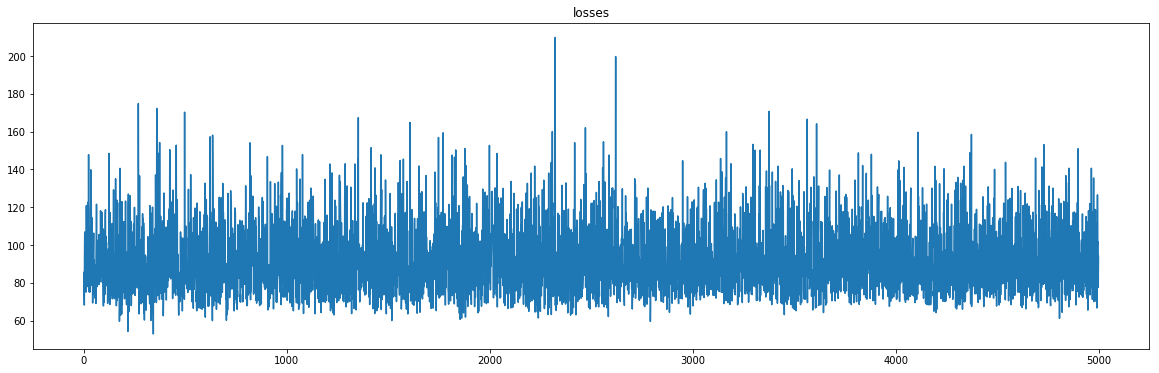

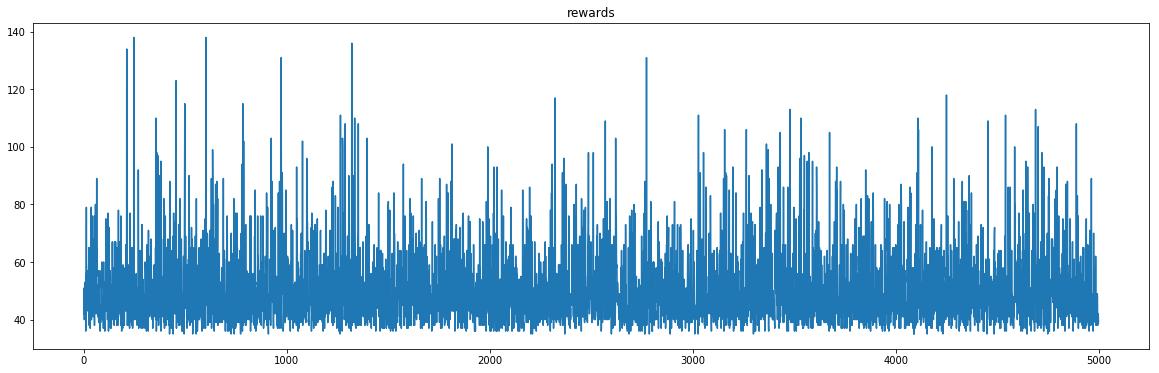

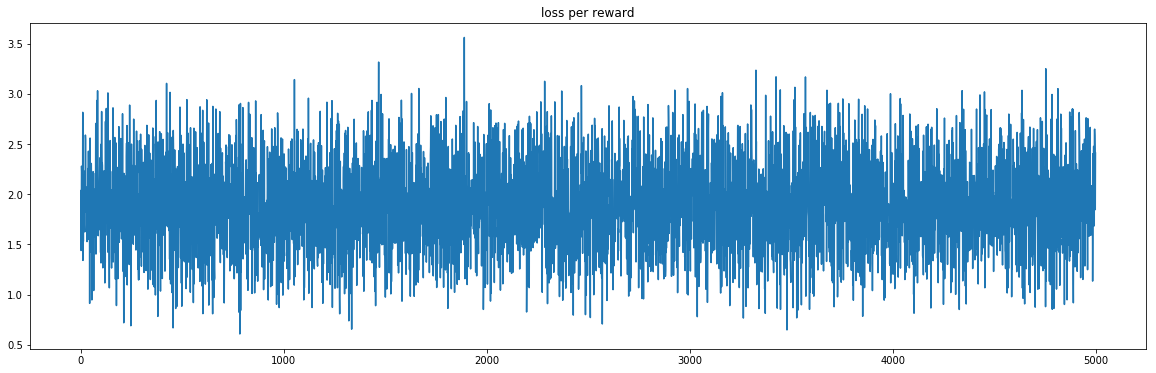

In [6]:
plt.figure(figsize=(20,6))
plt.plot(losses)
plt.title('losses')
plt.show()
plt.figure(figsize=(20,6))
plt.plot(rewards)
plt.title('rewards')
plt.show()
plt.figure(figsize=(20,6))
plt.plot([loss/reward for loss,reward in zip(losses,rewards)])
plt.title('loss per reward')
# plt.ylim(0,500)
plt.show()

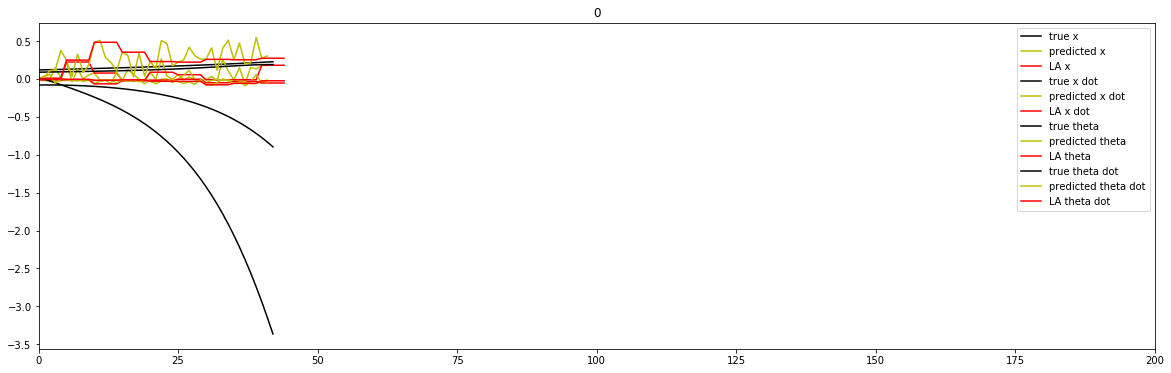

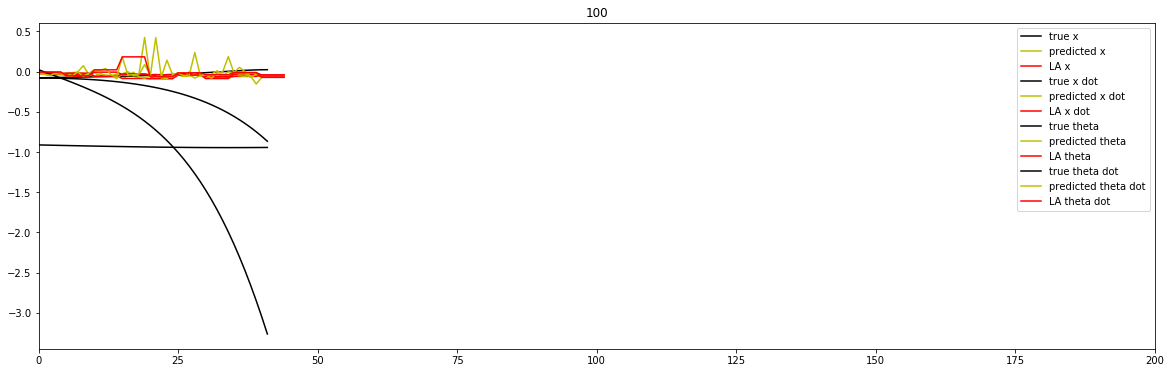

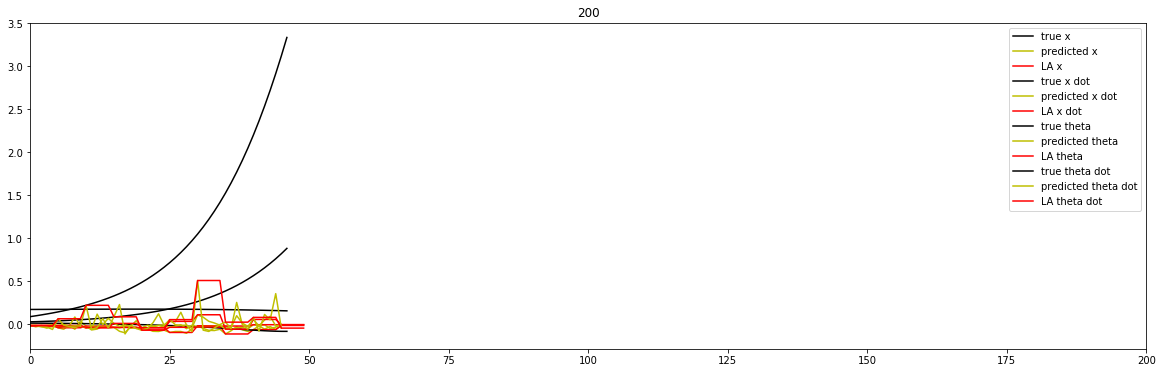

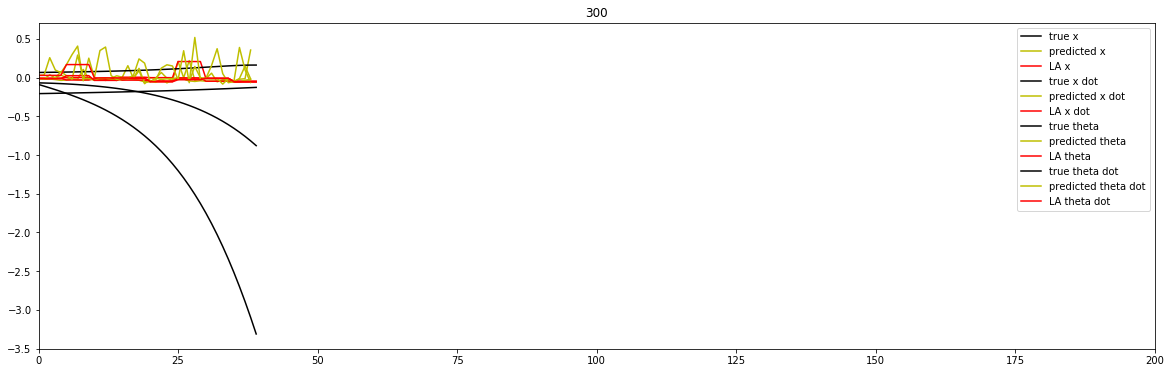

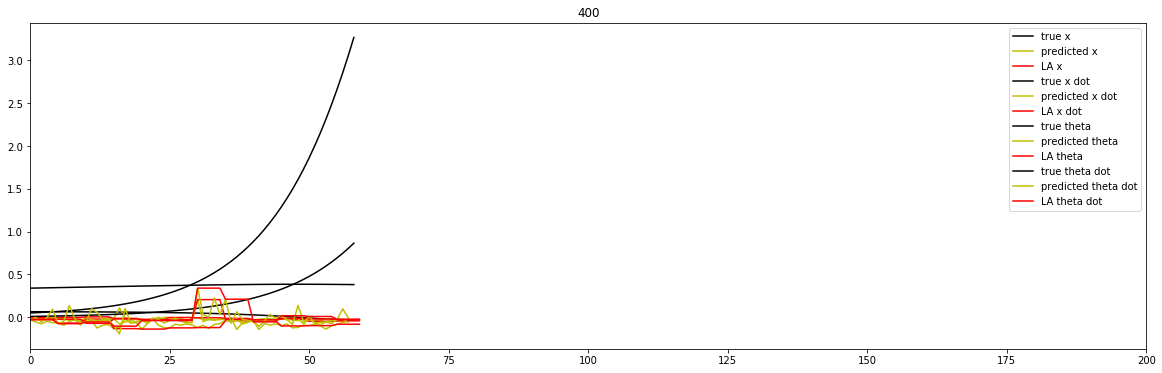

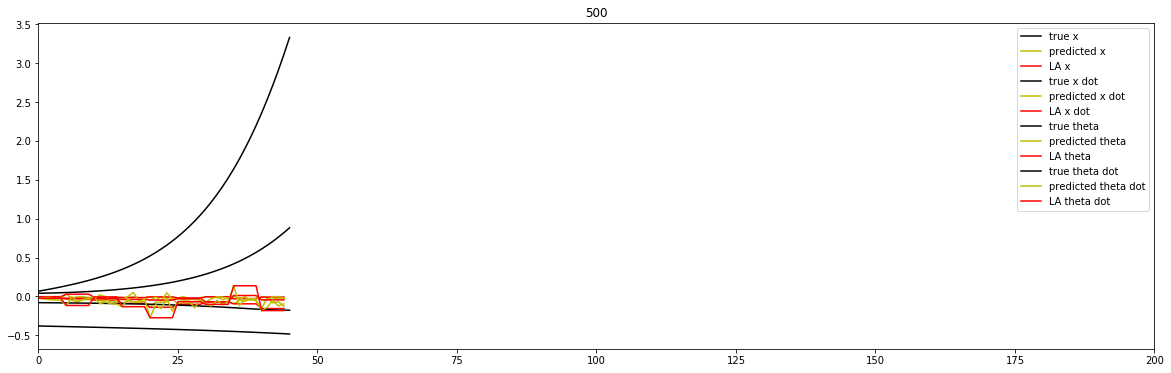

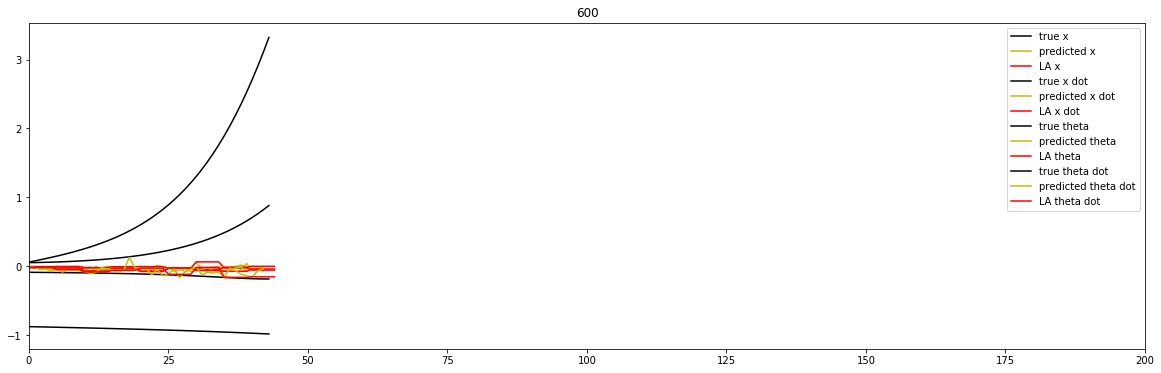

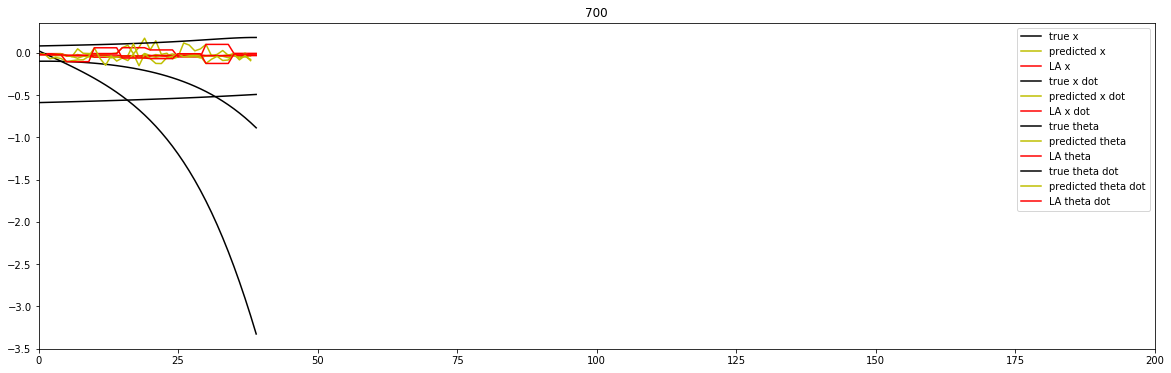

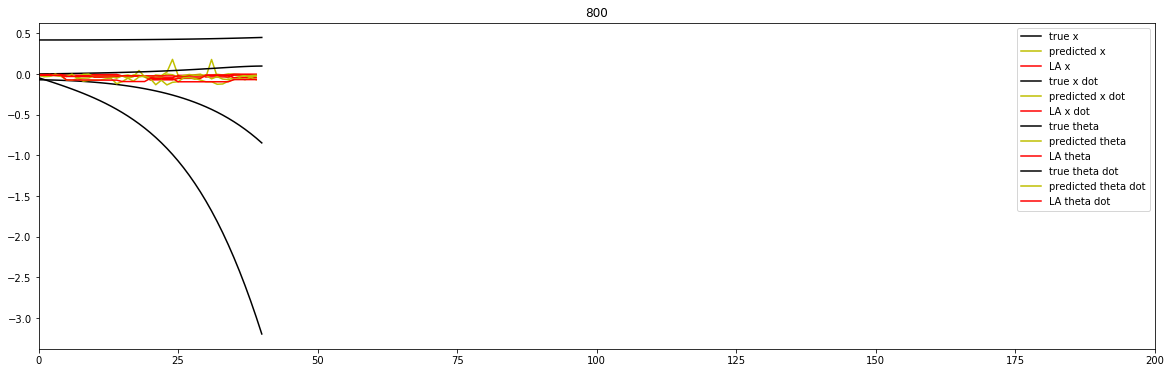

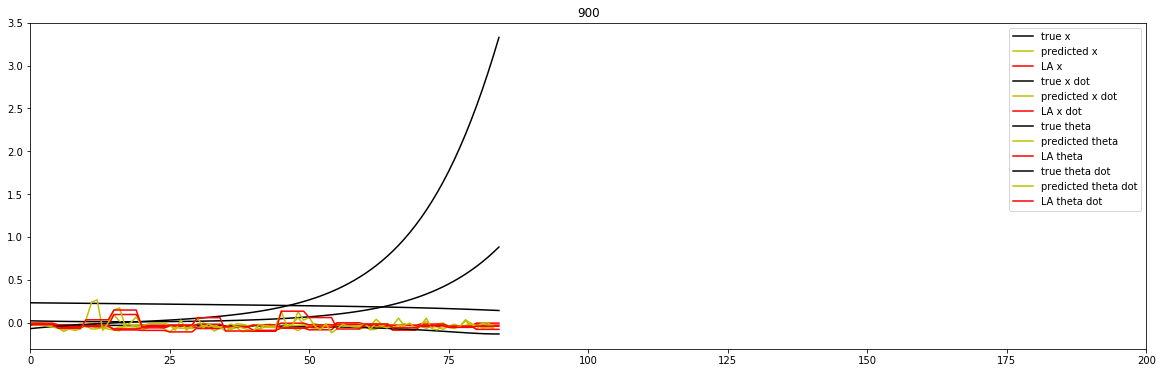

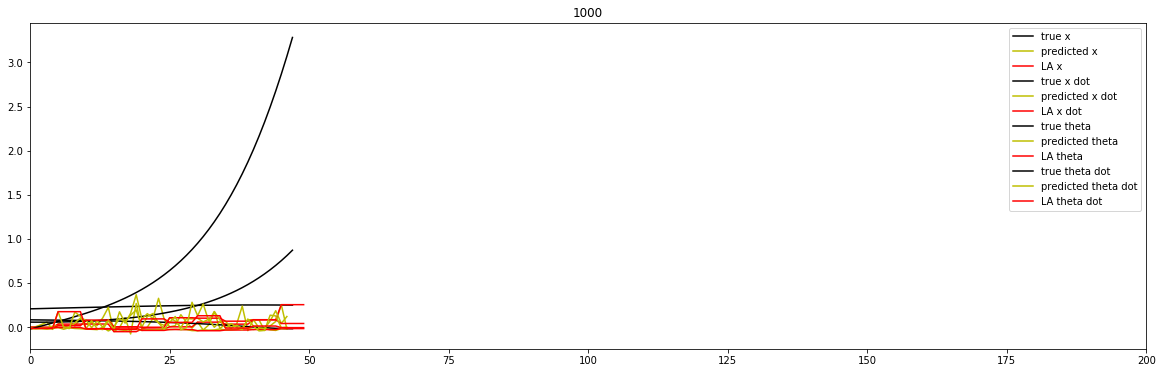

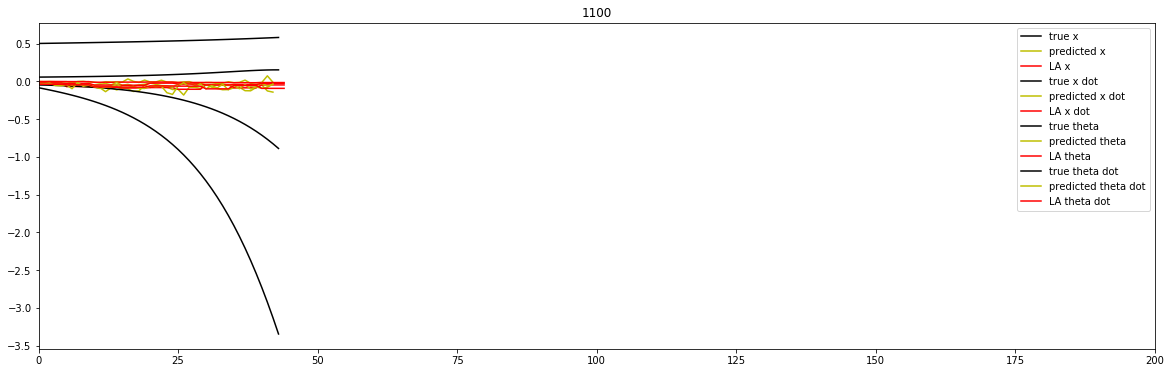

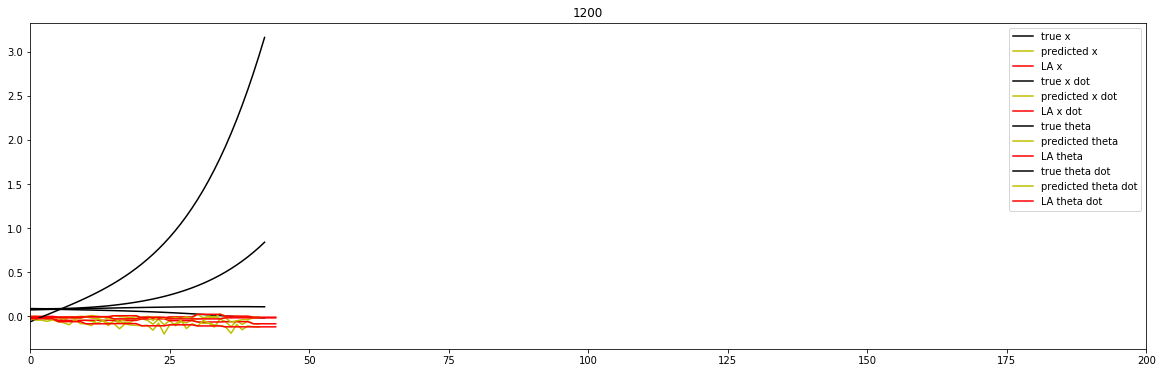

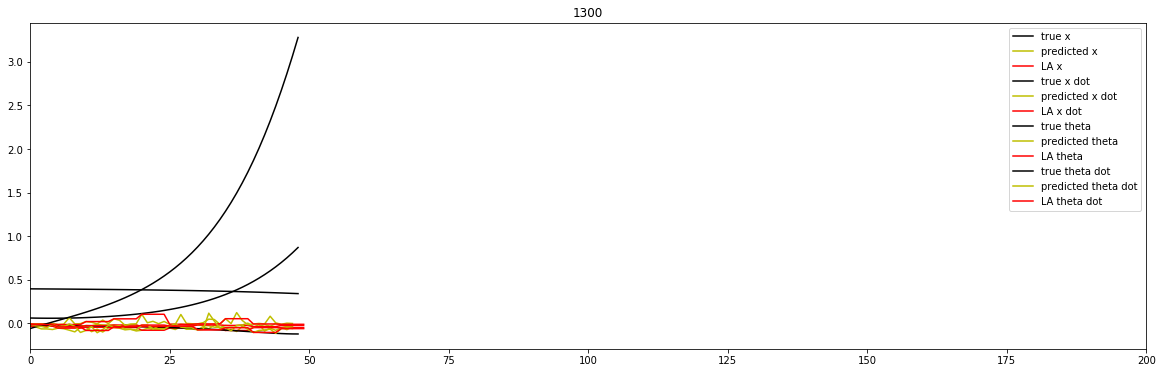

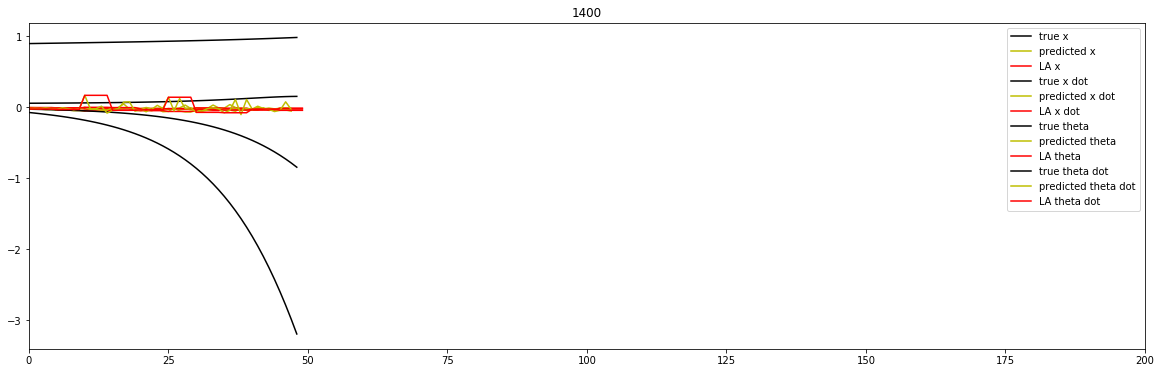

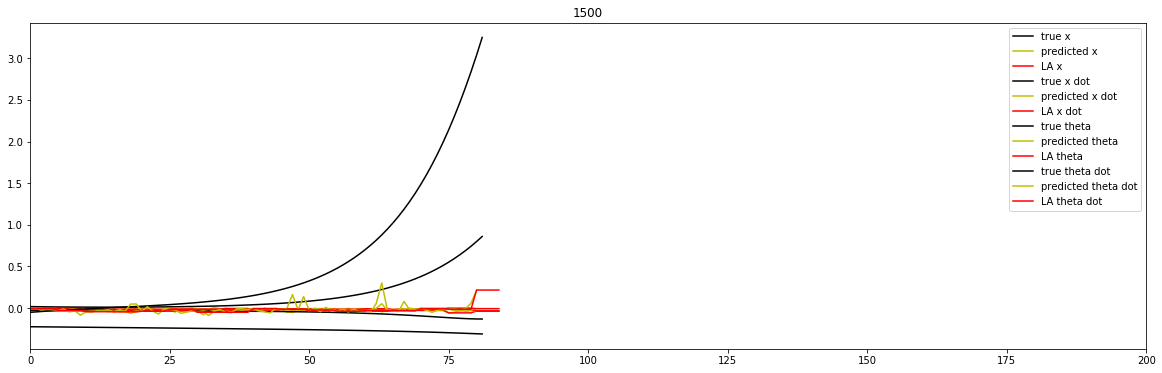

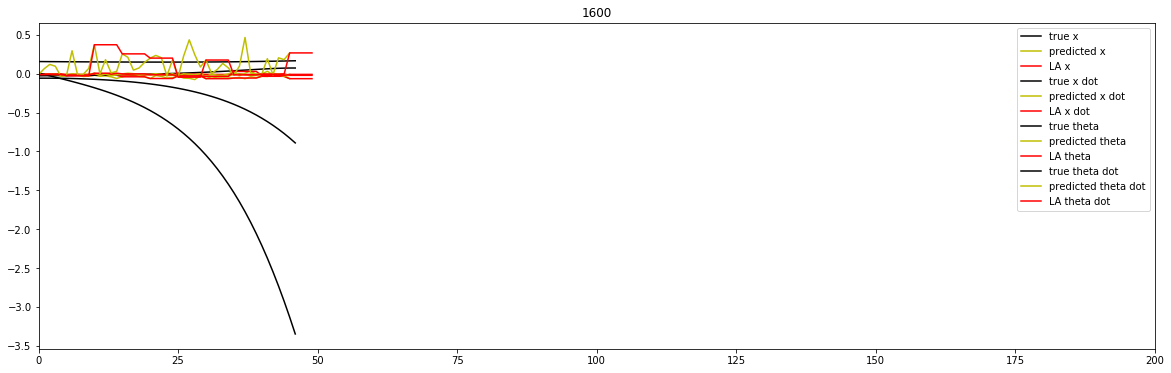

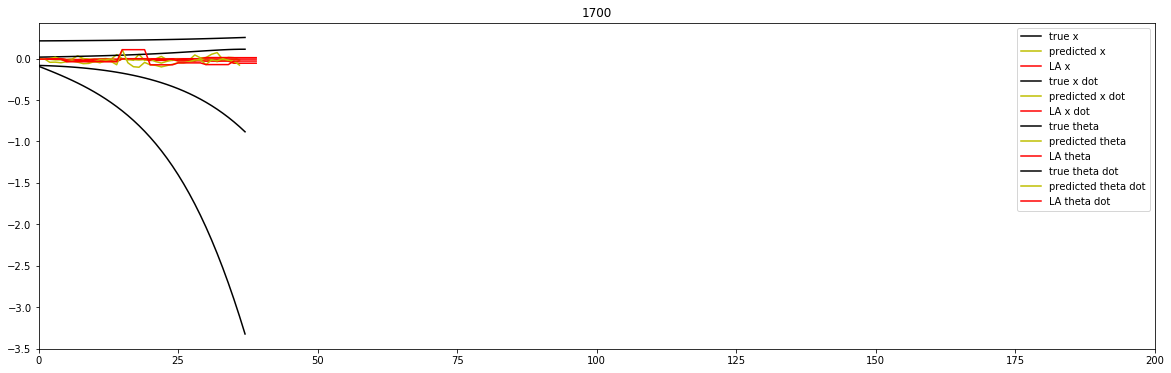

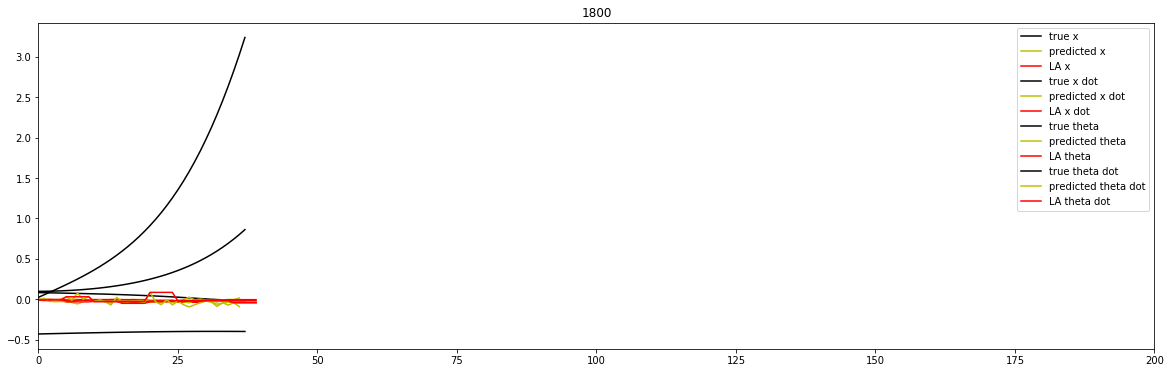

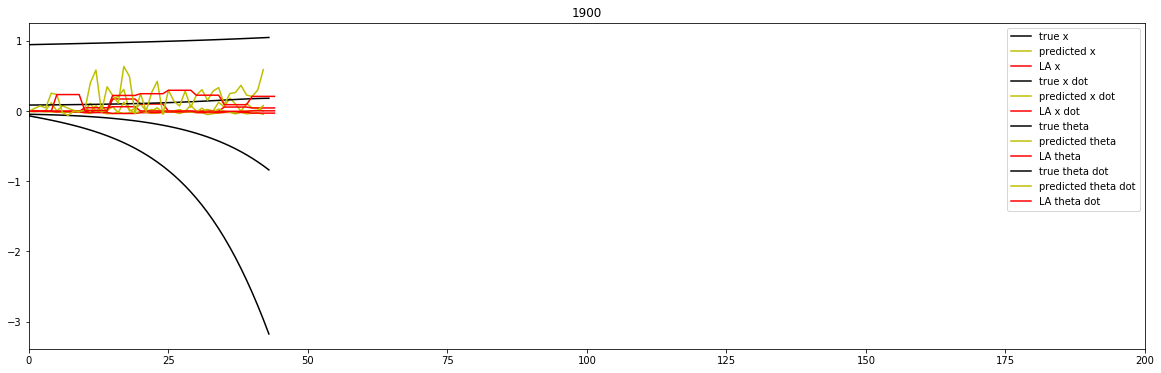

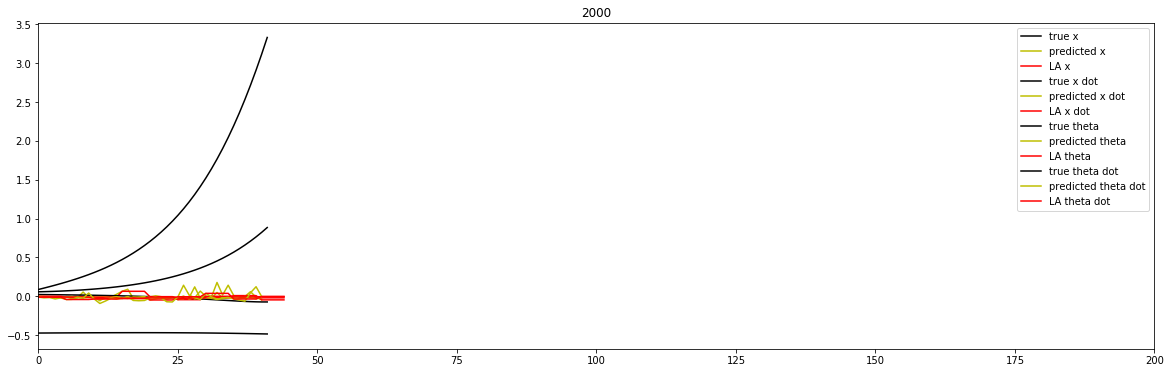

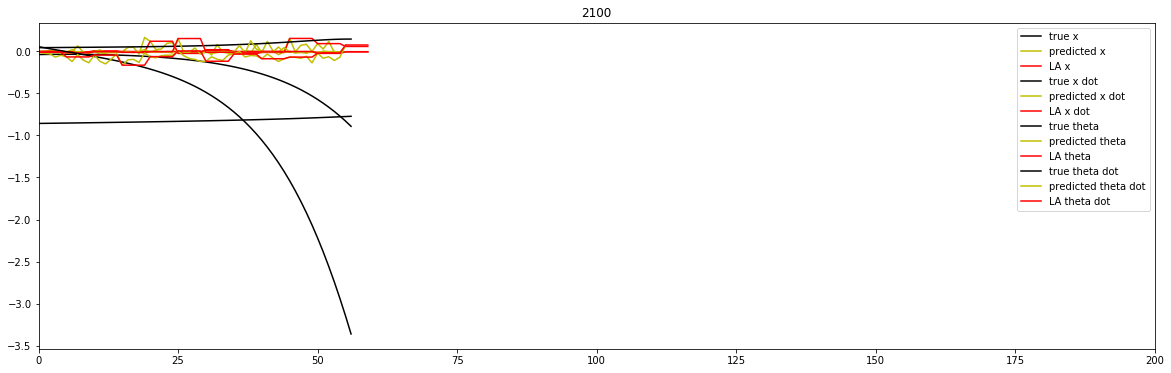

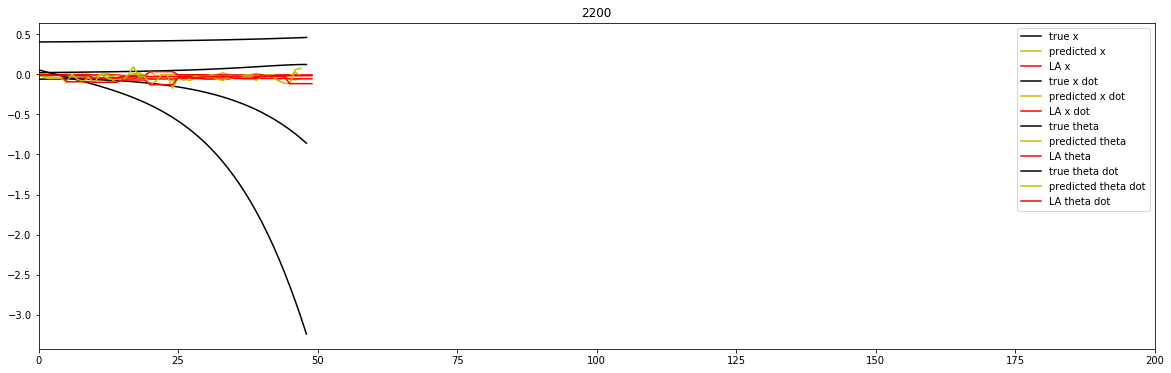

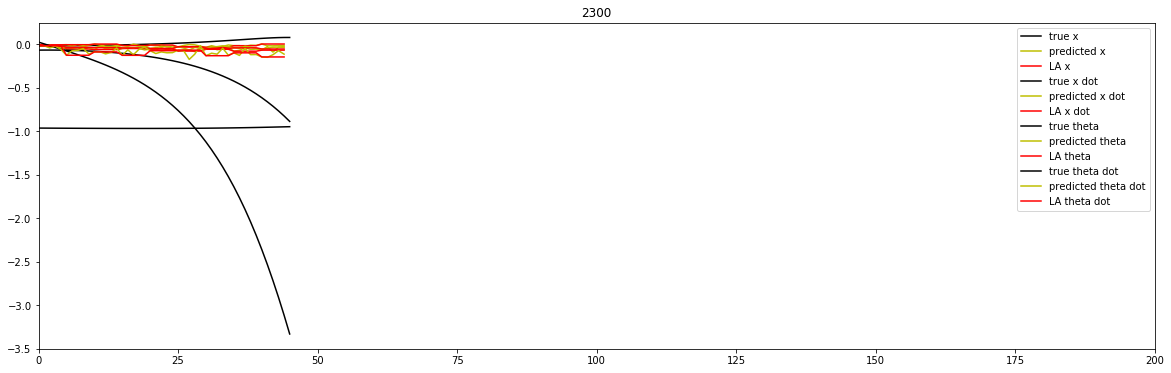

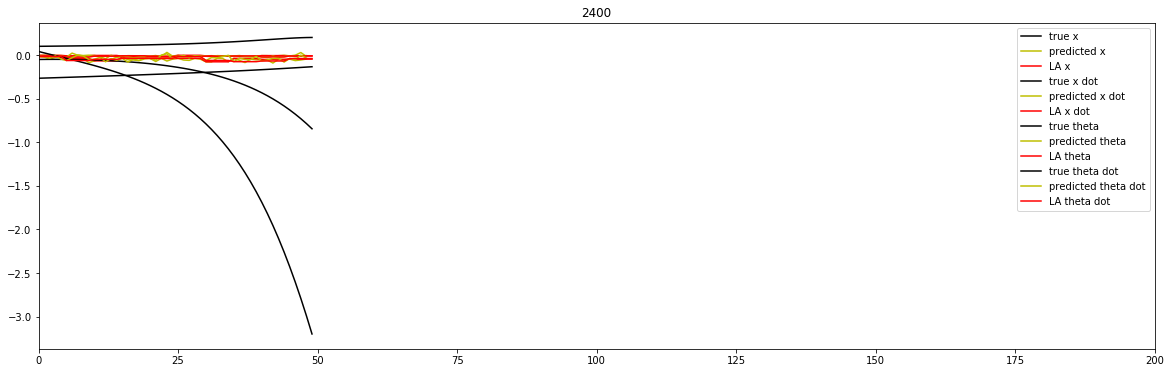

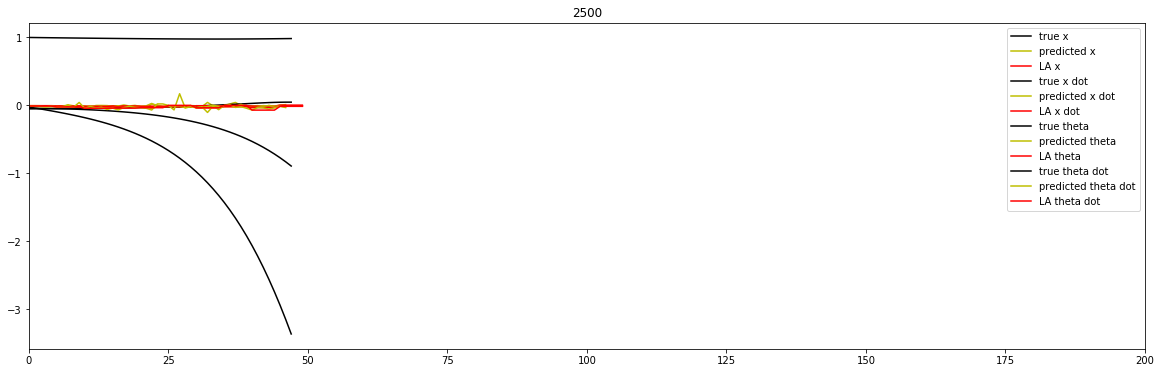

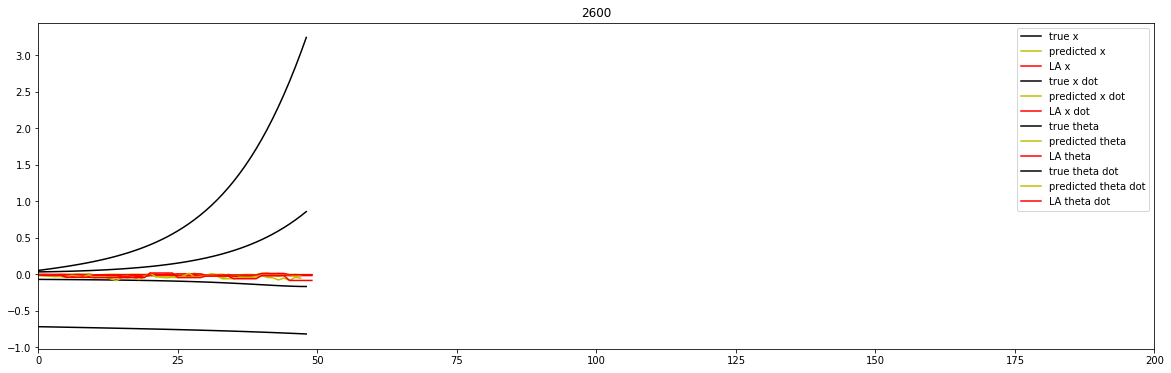

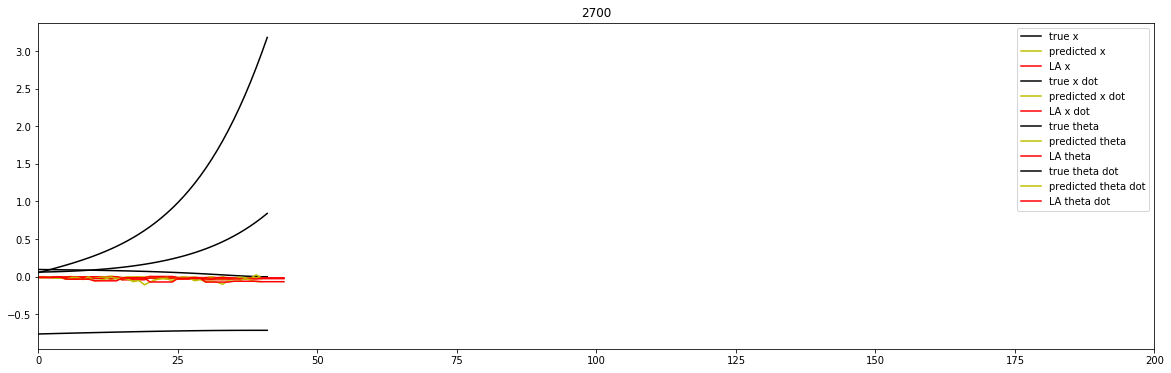

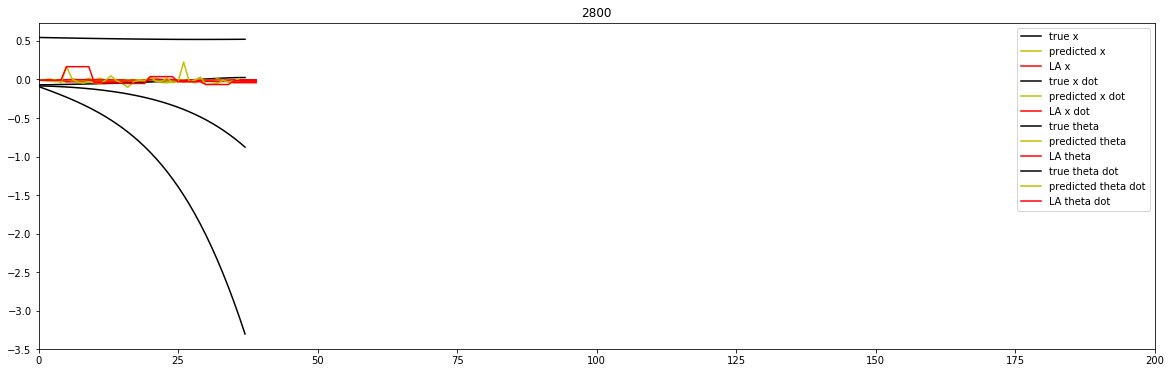

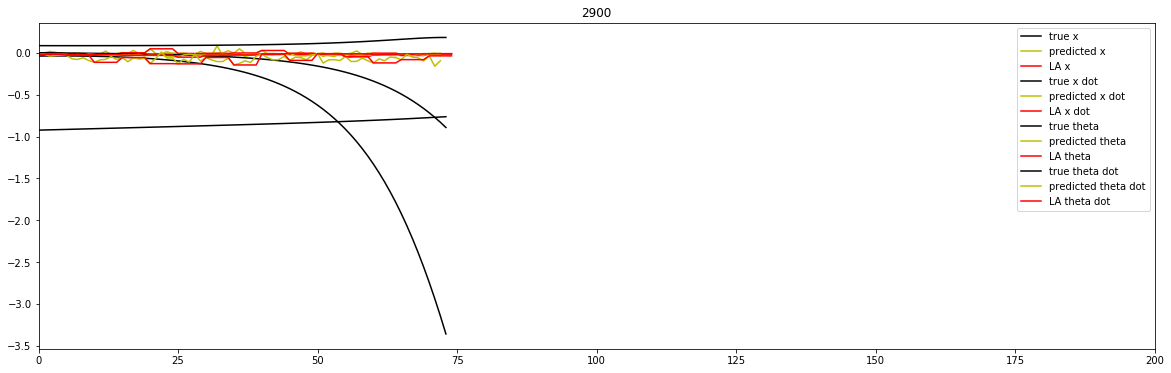

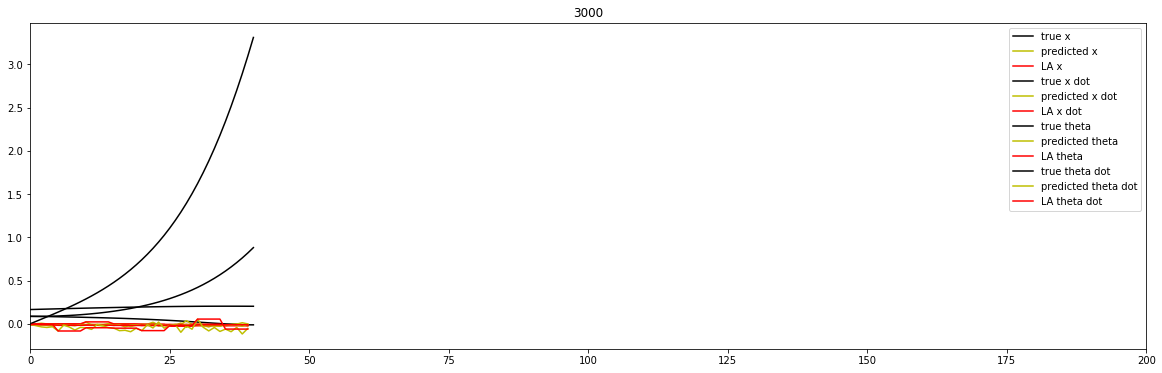

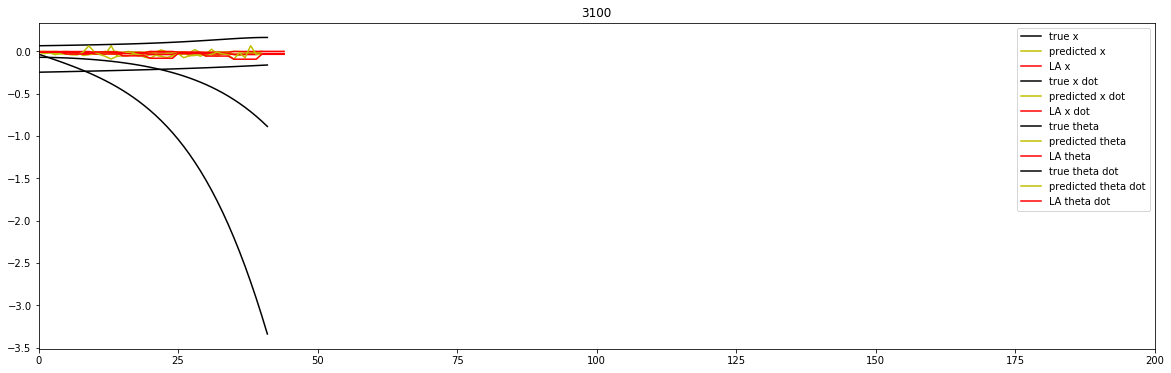

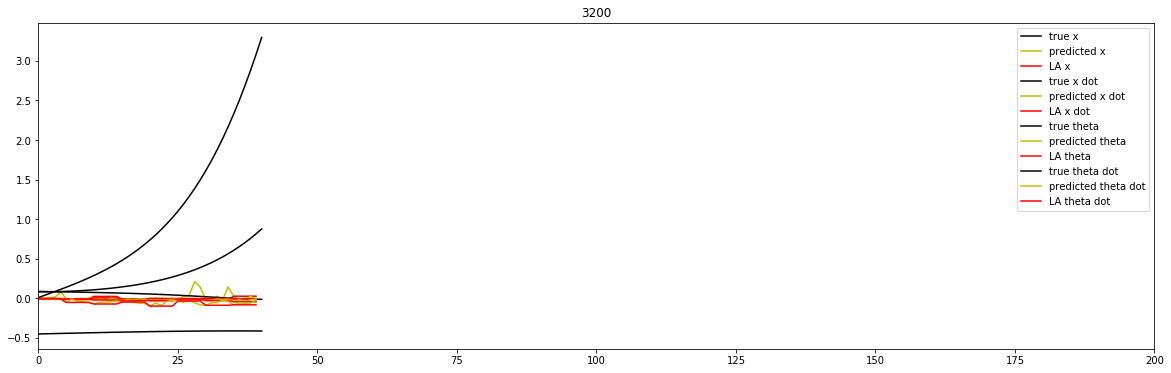

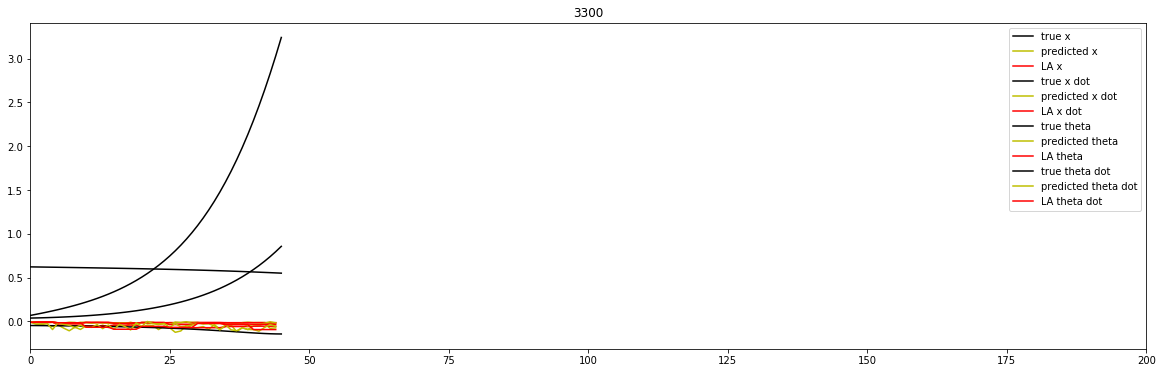

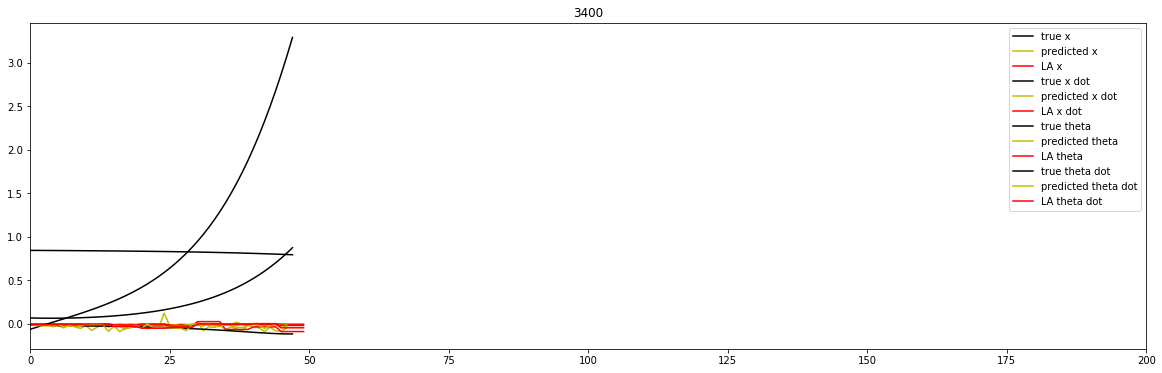

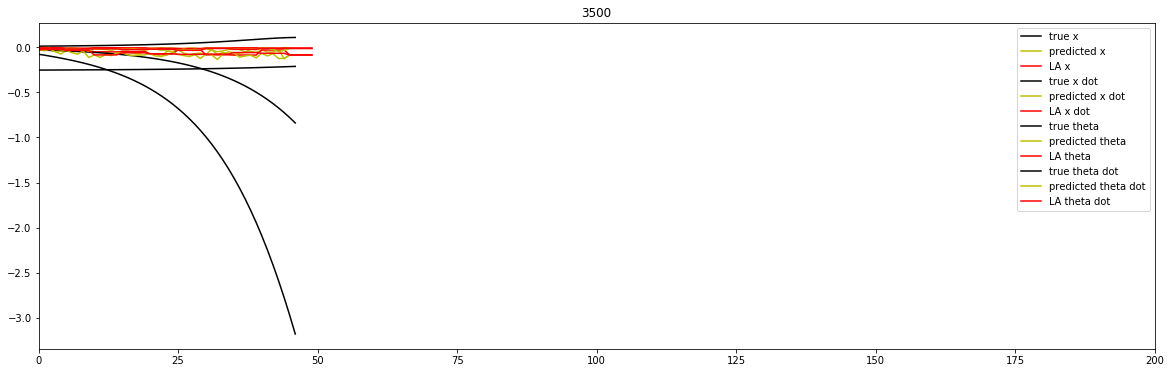

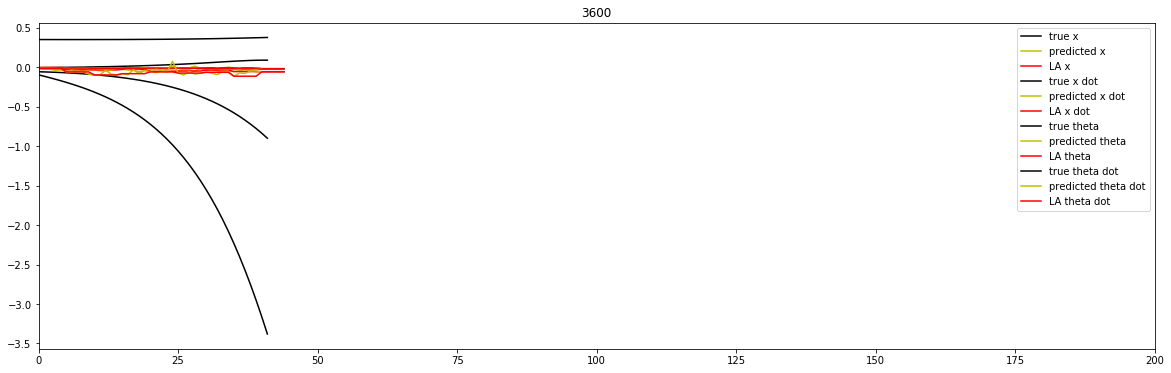

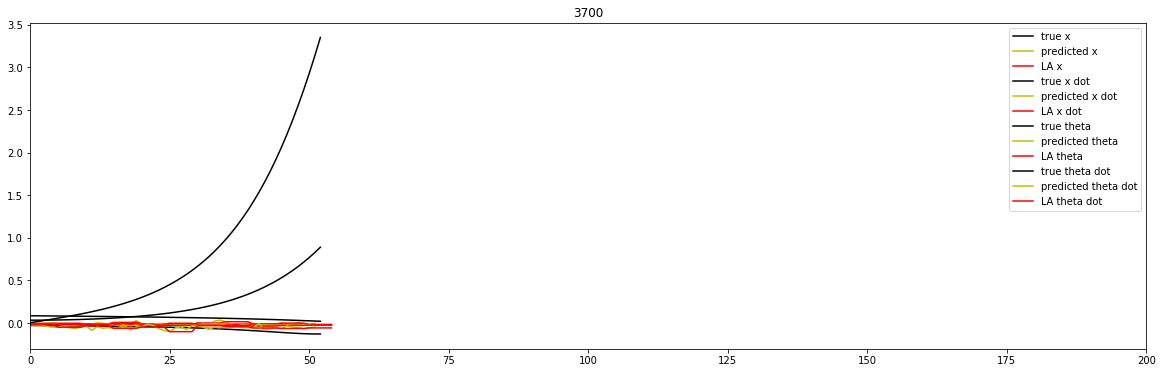

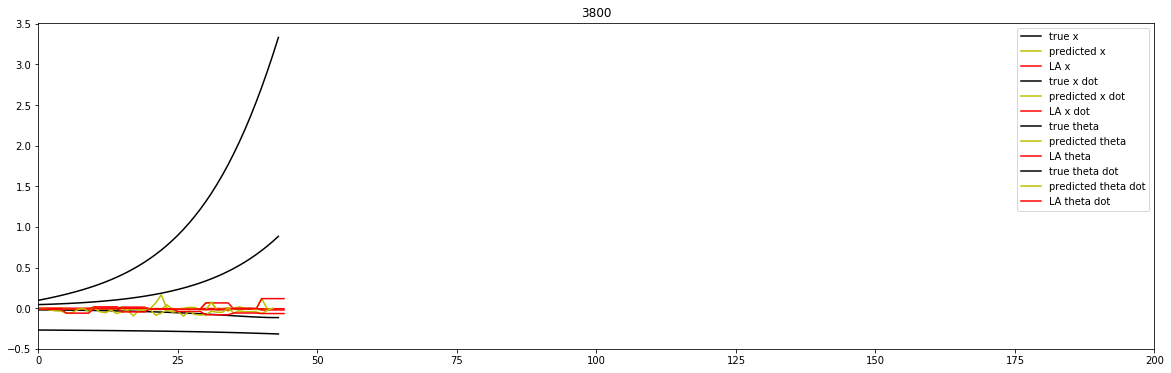

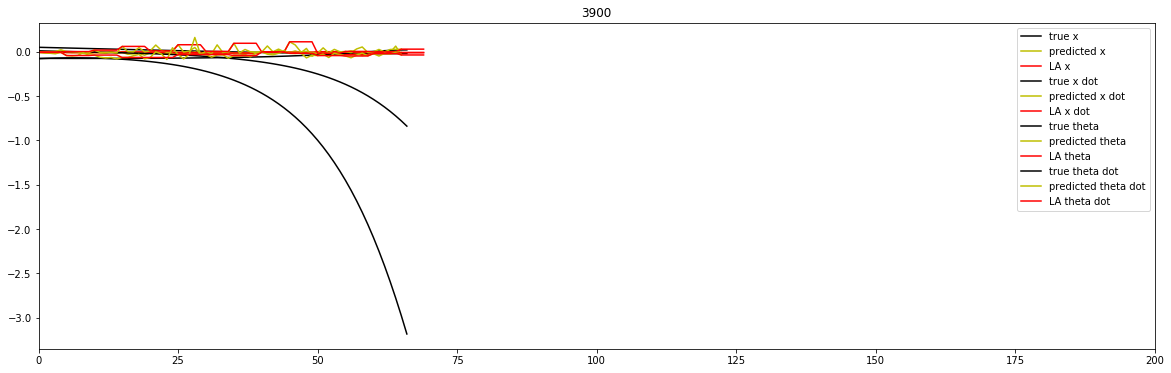

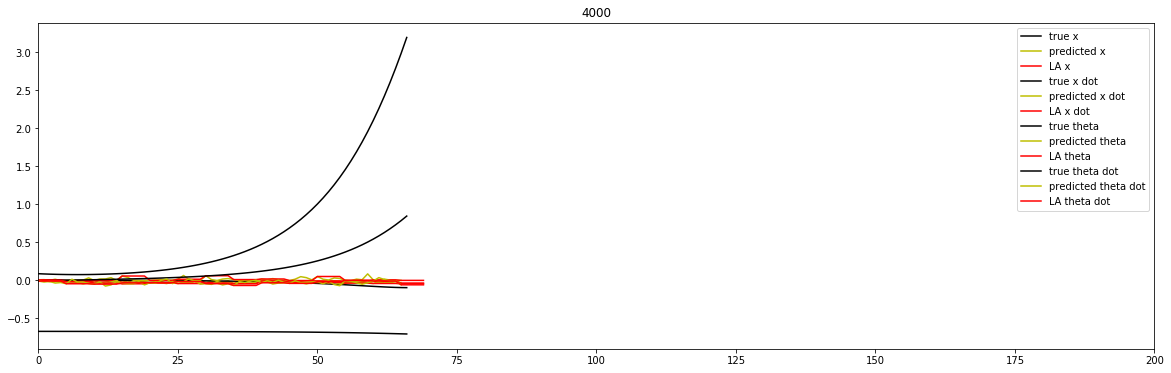

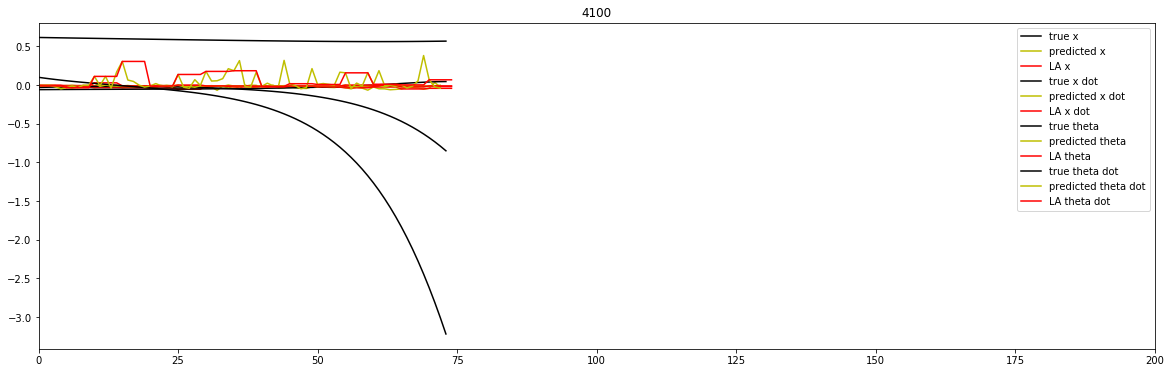

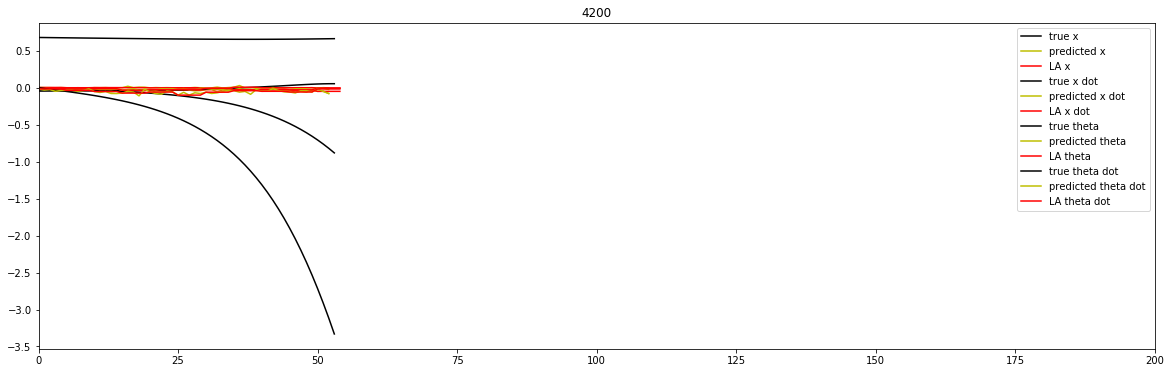

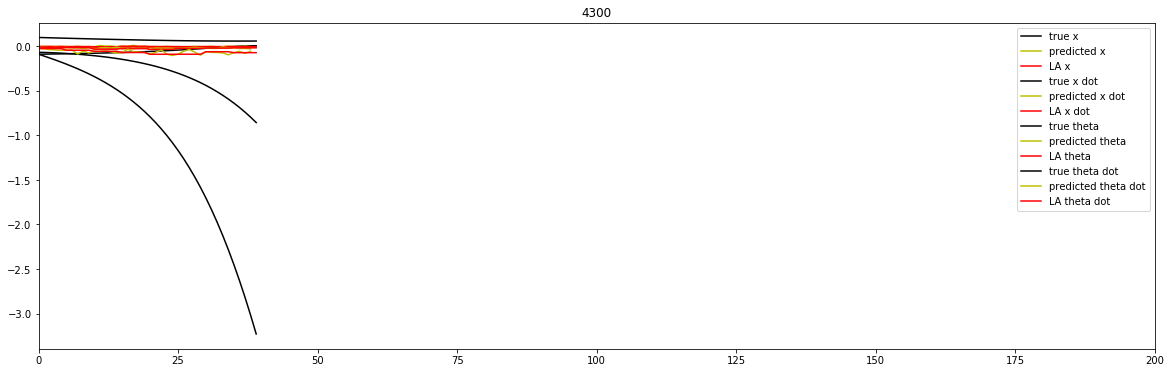

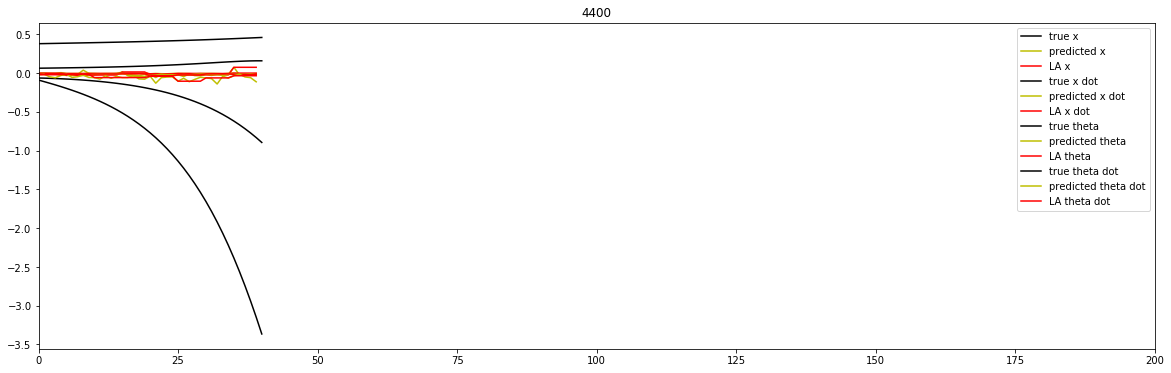

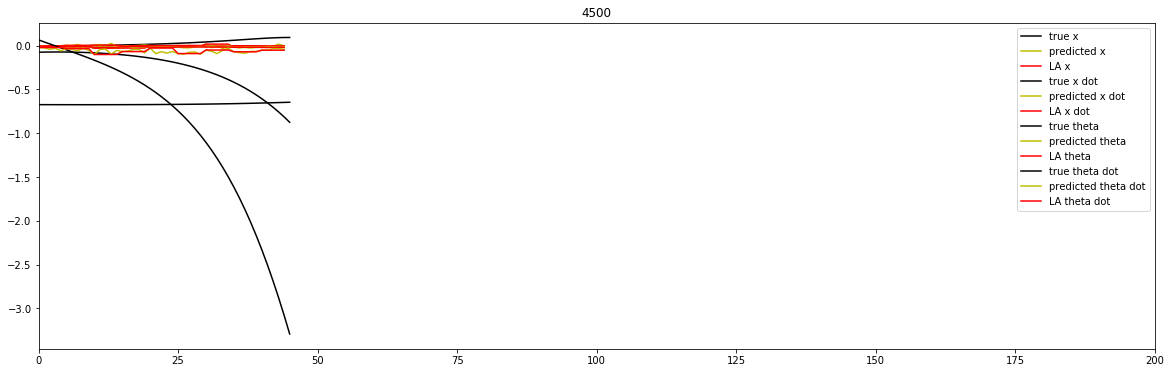

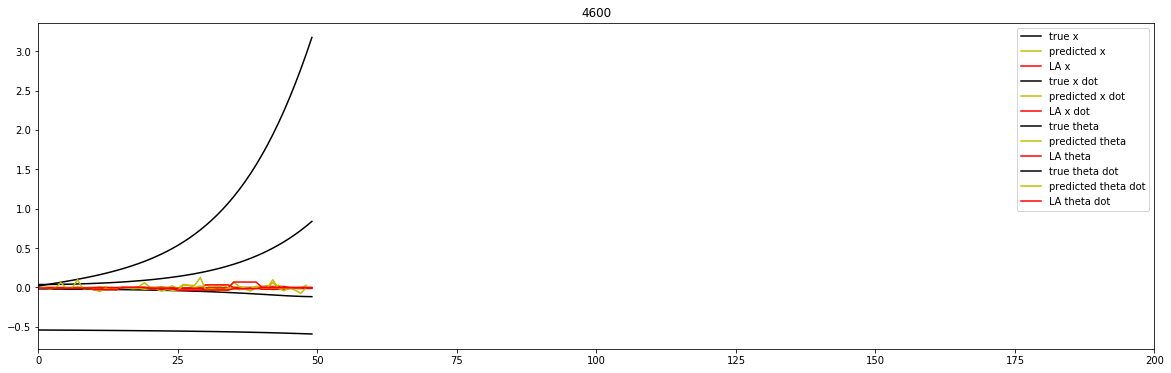

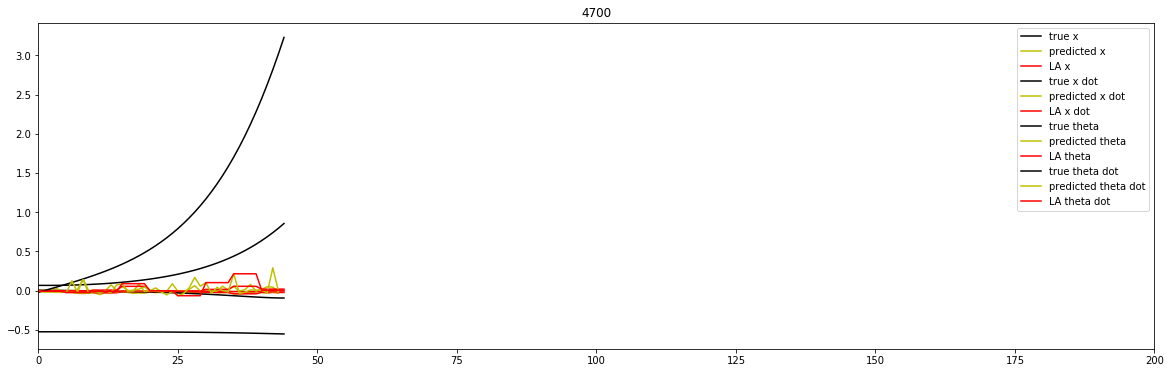

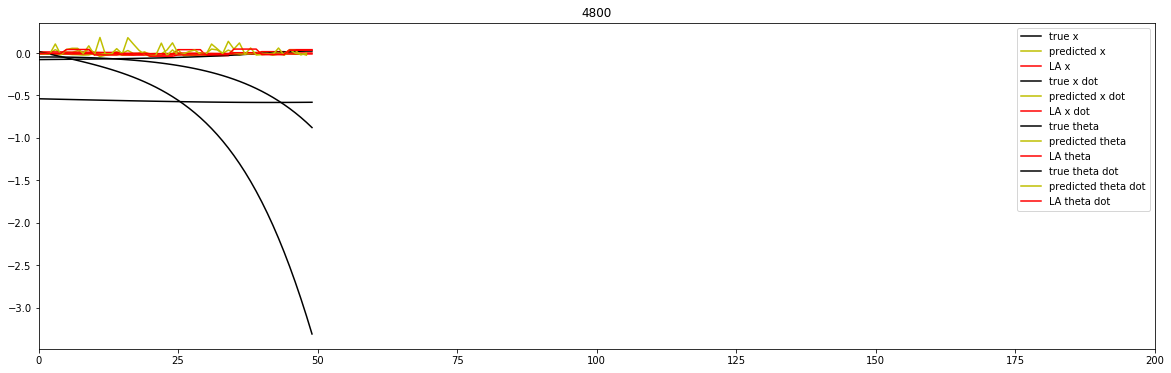

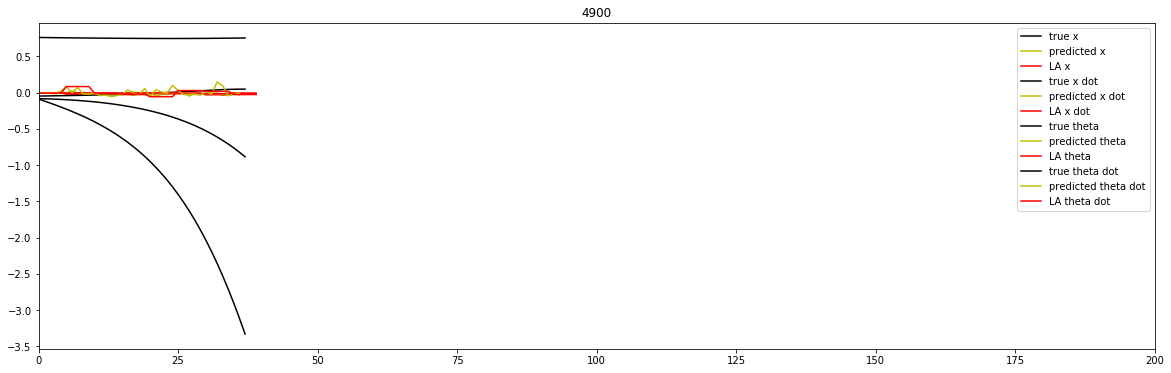

IndexError: list index out of range

<Figure size 1440x432 with 0 Axes>

In [7]:
truelabels = ['true x','true x dot', 'true theta','true theta dot']
predictedlabels = ['predicted x', 'predicted x dot', 'predicted theta', 'predicted theta dot']
lookaheadlabels = ['LA x', 'LA x dot', 'LA theta', 'LA theta dot']
for i in range(0,10000,100):
    plt.figure(figsize=(20,6))
    for j in range(4):
        plt.plot(np.squeeze(np.array(trajectories[i])).T[j], label = truelabels[j], color = 'k')
        plt.plot(np.squeeze(np.array(preds[i]))[j], label = predictedlabels[j], color = 'y')
        plt.plot(np.squeeze(np.array(look_ahead_preds[i])).T[j],label=lookaheadlabels[j],color='r')
    plt.legend()
    plt.title(i)
    plt.xlim(0,200)
    plt.show()